In [2]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install flax optax jetnet
# ! pip install flash_attention_jax
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [3]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict

import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, StateStore, train_step

from jetnet.datasets import JetNet, TopTagging

%load_ext autoreload
%autoreload 2

## The `JetNet` data

In [4]:
num_particles = 150

particle_data, jet_data = JetNet.getData(jet_type=["q", "g"], data_dir="../data/", num_particles=num_particles)

# Normalize everything BUT the class (first element of `jet_data`

EPS = 1e-7

jet_data_mean = jet_data[:, 1:].mean(axis=(0,))
jet_data_std = jet_data[:, 1:].std(axis=(0,))
jet_data[:, 1:] = (jet_data[:, 1:] - jet_data_mean) / (jet_data_std + EPS)

# Remove cardinality; keep pT, eta, mass as jet features for conditioning on
jet_data = jet_data[:, :-1]

# Get mask (to specify varying cardinality) and particle features to be modeled (eta, phi, pT)
particle_mask = particle_data[:, :, -1]
particle_data = particle_data[:, :, :3]

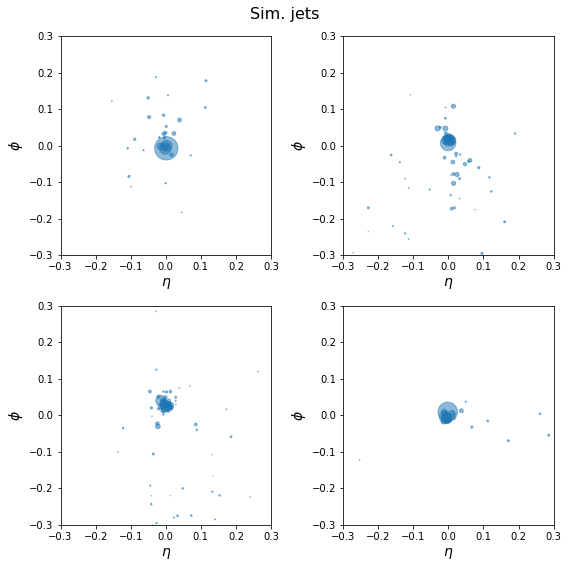

In [5]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2)

for i in range(4):
    
    ax = fig.add_subplot(gs[i])
    ax.scatter(*particle_data[i, :, :2].T, s=1000 * (particle_data[i, :, 2]), alpha=0.5)
    
    ax.set_xlabel(r"$\eta$", fontsize=14)
    ax.set_ylabel(r"$\phi$", fontsize=14)
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Sim. jets", fontsize=16)
plt.tight_layout()

In [6]:
batch_size = 16 * jax.device_count()
n_train = len(particle_data)

train_ds = tf.data.Dataset.from_tensor_slices((particle_data, jet_data, particle_mask))
train_ds = train_ds.cache()
train_ds = train_ds.repeat()

batch_dims=[jax.local_device_count(), batch_size // jax.device_count()]

for batch_size in reversed(batch_dims):
      train_ds = train_ds.batch(batch_size, drop_remainder=False)

train_ds = train_ds.shuffle(n_train, seed=42)
train_df = create_input_iter(train_ds)

## Instantiate and train model

In [9]:
transformer_dict = FrozenDict({"d_model":256, "d_mlp":512, "n_layers":5, "n_heads":4})  # Transformer args

vdm = VariationalDiffusionModel(gamma_min=-6.0, gamma_max=6.0, 
          n_layers=3, 
          d_embedding=8,
          d_hidden_encoding=64,
          timesteps=300, 
          d_t_embedding=16,
          d_feature=3,
          transformer_dict=transformer_dict,
          n_classes=2,
          embed_context=True)

In [10]:
# Past a test batch through to initialize model

n_smoke = 4

batch = np.array(particle_data[:n_smoke])
conditioning = np.zeros((n_smoke, jet_data.shape[-1]))
mask = np.array(particle_mask[:n_smoke])

rng = jax.random.PRNGKey(42)
out, params = vdm.init_with_output({"sample": rng, "params": rng}, batch, np.ones_like(conditioning), mask);

In [11]:
print(f"Params: {param_count(params):,}")

Params: 2,679,067


In [12]:
# Evaluate the loss for good measure
loss_vdm(params, vdm, rng, batch, np.zeros_like(conditioning), mask)

Array(21206.102, dtype=float32)

In [13]:
train_steps = 50_000

opt = optax.chain(
    optax.scale_by_schedule(optax.cosine_decay_schedule(1.0, train_steps, 1e-5)),
    optax.adamw(3e-4, weight_decay=1e-4),
    optax.scale_by_schedule(optax.linear_schedule(0.0, 1.0, 5000)))

store = StateStore(params, opt.init(params), rng, 0)
pstore = replicate(store)

In [ ]:
batches = create_input_iter(train_ds)

vals = []
with trange(train_steps) as t:
    for i in t:
        pstore, val = train_step(pstore, loss_vdm, vdm, next(batches), opt)
        v = unreplicate(val)
        t.set_postfix(val=v)
        vals.append(v)

## Conditional generation

For simplicity, let's just condition the model on random $(\mathrm{type}, p_T, \eta, M)$ from the training set.

In [40]:
import numpy as vnp

n_samples = 4000
idx_rnd = vnp.random.choice(vnp.arange(len(jet_data)), size=n_samples, replace=False)

cond = jet_data[idx_rnd]
mask = particle_mask[idx_rnd]

x_samples = generate(vdm, unreplicate(pstore).params, rng, (n_samples, num_particles), cond, mask=mask)
x_samples = x_samples.mean() * mask[:, :, None]

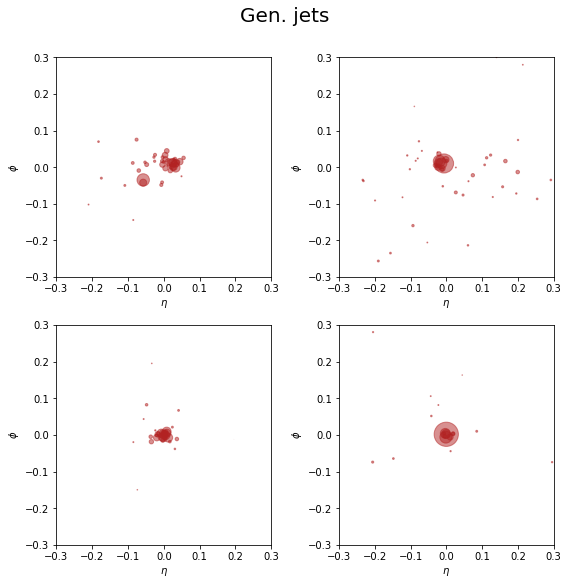

In [41]:
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2)

for i in range(4):
    
    ax = fig.add_subplot(gs[i])
    
    ax.scatter(*x_samples[i, :, :2].T, s=1000 * (x_samples[i, :, 2]), alpha=0.5, color="firebrick")
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets", fontsize=20, y=1.01)
plt.tight_layout()

## Evaluate

Compare summaries between genreated and training samples.

In [42]:
# idx_rnd = vnp.random.choice(vnp.arange(len(jet_data)), size=n_samples, replace=False)
x = particle_data[idx_rnd] * particle_mask[idx_rnd, :, None]

In [43]:
import energyflow as ef

def jet_masses(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    masses = ef.ms_from_p4s(jets_p4s.sum(axis=1))
    return masses

def jet_ys(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    ys = ef.ys_from_p4s(jets_p4s.sum(axis=1))
    return ys

def jet_etas(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    etas = ef.etas_from_p4s(jets_p4s.sum(axis=1))
    return etas

def jet_phis(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    phis = ef.phis_from_p4s(jets_p4s.sum(axis=1), phi_ref=0)
    return phis

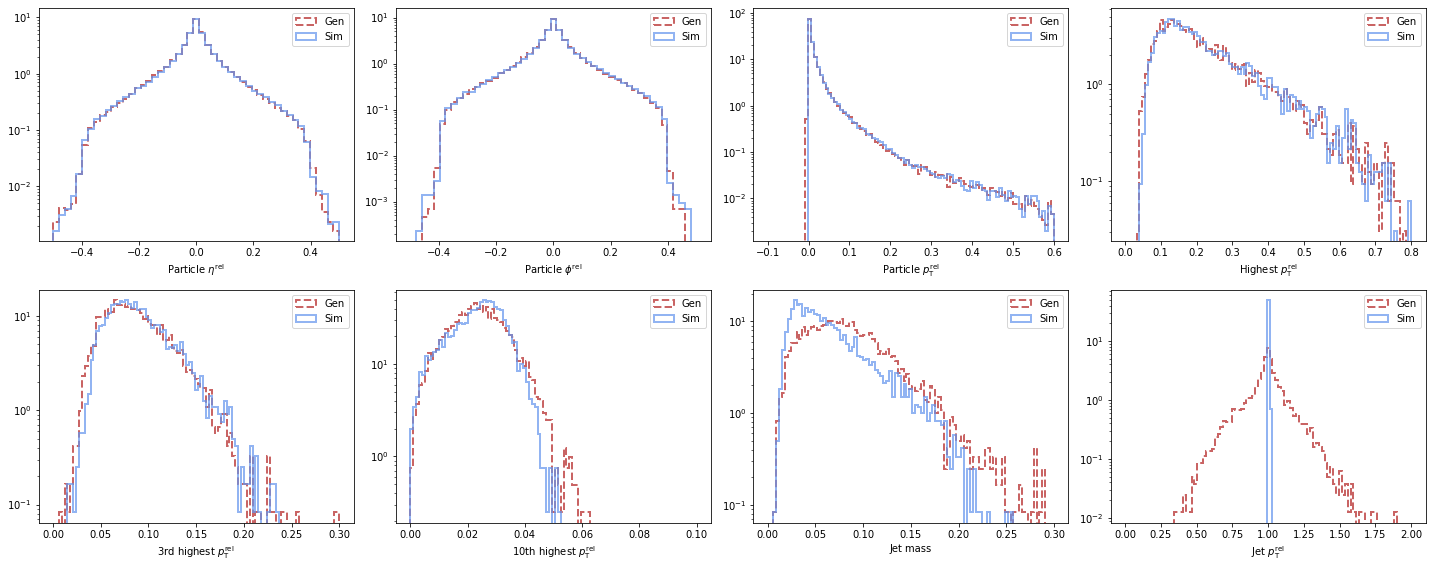

In [44]:
color_sim = "cornflowerblue"
color_gen = "firebrick"

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 4)


x_samples = x_samples.at[x_samples == 0.].set(-999.)
x[x == 0.] = -999.

#####

ax = fig.add_subplot(gs[0])

i_feat = 0

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\eta^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[1])

i_feat = 1

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = (np.concatenate(np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\phi^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[2])

i_feat = 2

bins= np.linspace(-0.1, 0.6, 100)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $p_\mathrm{T}^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

ax.set_yscale("log")
ax.legend()

x_samples = x_samples.at[x_samples == -999].set(0.)
x[x == -999] = 0.

######

ax = fig.add_subplot(gs[3])

bins = np.linspace(0., 0.8, 100)
ax.hist(np.max(x_samples[:, :, 2], -1), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(np.max(x[:, :, 2], -1), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[4])

bins = np.linspace(0., 0.3, 100)
ax.hist(np.sort(x_samples[:, :, 2])[:, -3], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(np.sort(x[:, :, 2])[:, -3], histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"3rd highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[5])

bins = np.linspace(0., 0.1, 100)
ax.hist(np.sort(x_samples[:, :, 2])[:, -10], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(np.sort(x[:, :, 2])[:, -10], histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"10th highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[6])

bins= np.linspace(0., 0.3, 100)

jet_mass = jet_masses(np.array([x_samples[:, :, 2], x_samples[:, :, 0], x_samples[:, :, 1]]).transpose(1,2,0))
ax.hist(jet_mass, histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

jet_mass = jet_masses(np.array([x[:, :, 2], x[:, :, 0], x[:, :, 1]]).transpose(1,2,0))
ax.hist(jet_mass, histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet mass")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[7])

bins= np.linspace(0., 2, 100)

ax.hist(np.abs(x_samples[:, :, 2]).sum(-1), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(np.abs(x[:, :, 2]).sum(-1), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

plt.tight_layout()